In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
from ripple_heterogeneity.readout import readout_explained_var
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats
from neo.rawio import neuroscoperawio

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [42]:
basepath = r"Z:\Data\HMC1\day8"

st, cell_metrics = loading.load_spikes(
    basepath, brainRegion=["CA1","PFC","MEC"], putativeCellType="Pyr"
)
ripples = loading.load_ripples_events(basepath)
ripple_epochs = nel.EpochArray(np.array([ripples.start,ripples.stop]).T).expand(0.2)

st, ripple_epochs

(<SpikeTrainArray at 0x197af0c0ee0: 158 units> at 20000 Hz,
 <EpochArray at 0x197c8e376a0: 6,641 epochs> of length 47:09:996 minutes)

In [43]:
cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)

In [44]:
ca1_deep_idx = cell_metrics.brainRegion.str.contains("CA1") & cell_metrics.deepSuperficial.str.contains("Deep")
ca1_sup_idx = cell_metrics.brainRegion.str.contains("CA1") & cell_metrics.deepSuperficial.str.contains("Superficial")
pfc_idx = cell_metrics.brainRegion.str.contains("PFC")
mec_idx = cell_metrics.brainRegion.str.contains("MEC")


In [6]:
from xml.etree import ElementTree
def parse_xml_channel_groups(filename):
    filename = filename.replace('.xml', '').replace('.dat', '')

    tree = ElementTree.parse(filename + '.xml')
    root = tree.getroot()

    # find channels
    channel_group = []
    for grp_index, xml_chx in enumerate(
            root.find('anatomicalDescription').find('channelGroups').findall('group')):
        for xml_rc in xml_chx:
            channel_group.append([int(xml_rc.text),grp_index])
    return np.array(channel_group)

In [45]:
reader = neuroscoperawio.NeuroScopeRawIO('Z:/Data/HMC1/day8/day8')
reader.parse_header()
channel_group = parse_xml_channel_groups(reader.filename)
shank = 9
channel_indexes = channel_group[channel_group[:,1] == shank,0]

In [74]:
channel_indexes = [293,314,32,416]

In [75]:
# epoch of time around ripple, which was previously found
rip = 1
seconds_idx = np.array([ripple_epochs[rip].start,ripple_epochs[rip].stop])
# seconds_idx = np.array([7.320,7.620])

# convert to index
to_idx = (seconds_idx*reader.get_signal_sampling_rate()).astype(int)
# get chunk of data
raw_sigs = reader.get_analogsignal_chunk(i_start=to_idx[0],
                                        i_stop=to_idx[1],
                                        channel_indexes=channel_indexes)

In [ ]:
plt.figure(figsize=(4,12))
channel_offset = -np.arange(raw_sigs.shape[1])*4500
x = np.arange(raw_sigs.shape[0]) / reader.get_signal_sampling_rate()
plt.plot(x,raw_sigs + channel_offset,color='k',linewidth=1)
ax = plt.gca()
ax.set_yticks(channel_offset)
ax.set_yticklabels(channel_indexes)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.xlabel('time (sec)')
plt.ylabel('channel id')
plt.show()

<Figure size 432x288 with 0 Axes>

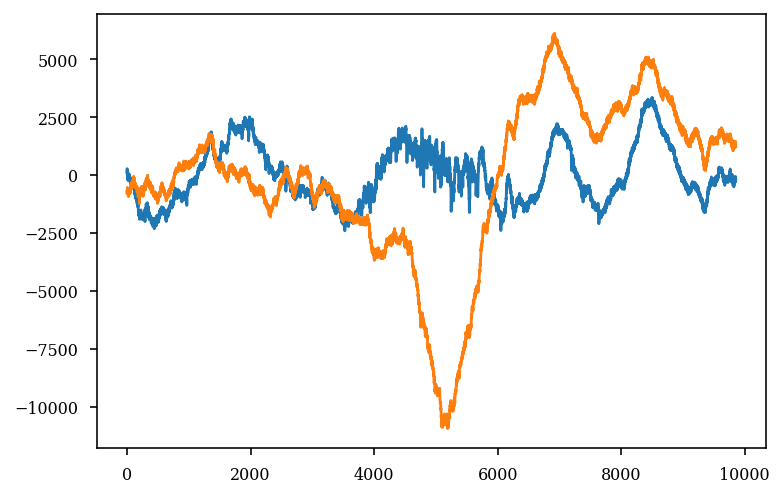

<Figure size 432x288 with 0 Axes>

In [53]:
plt.plot(raw_sigs[:,0])
plt.plot(raw_sigs[:,-1])

plt.figure()

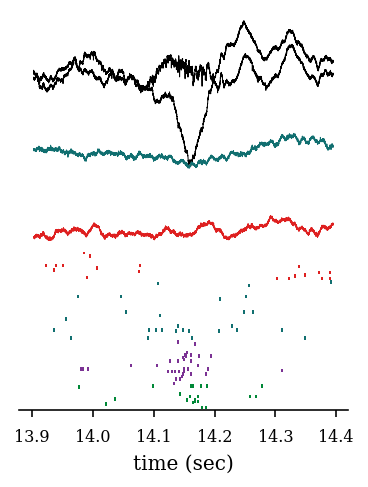

In [102]:
group_colors = {"MEC": "#de2020", "PFC": "#116f70","Deep": "#7b3294", "Superficial": "#008837"}
rip = 1

fig, axs = plt.subplots(4,1, figsize=functions.set_size('thesis', fraction=.5, subplots=(2, 1)), sharex=True)
fig.subplots_adjust(hspace = -0.50, wspace=.1)
axs = axs.ravel()

ts = np.arange(ripple_epochs[rip].start, ripple_epochs[rip].stop, 1/reader.get_signal_sampling_rate())
axs[0].plot(ts, raw_sigs[:,0:2], color='k', linewidth=.5)

axs[1].plot(ts, raw_sigs[:,2], color=group_colors["PFC"], linewidth=.5)

axs[2].plot(ts, raw_sigs[:,3], color=group_colors["MEC"], linewidth=.5)

npl.rasterplot(st.iloc[:,ca1_sup_idx][ripple_epochs[rip]], lw=1,lh=3, ax=axs[3], color=group_colors["Superficial"], vertstack=True)
npl.rasterplot(st.iloc[:,ca1_deep_idx][ripple_epochs[rip]], lw=1,lh=3, ax=axs[3], color=group_colors["Deep"], vertstack=True)
npl.rasterplot(st.iloc[:,pfc_idx][ripple_epochs[rip]], lw=1,lh=3, ax=axs[3], color=group_colors["PFC"], vertstack=True)
npl.rasterplot(st.iloc[:,mec_idx][ripple_epochs[rip]], lw=1,lh=3, ax=axs[3], color=group_colors["MEC"], vertstack=True)

axs[0].get_shared_y_axes().join(axs[0], *axs[:-1])
axs[0].axes.get_yaxis().set_visible(False)
axs[1].axes.get_yaxis().set_visible(False)
axs[2].axes.get_yaxis().set_visible(False)

axs[0].set_axis_off()
axs[1].set_axis_off()
axs[2].set_axis_off()

axs[3].axes.get_yaxis().set_visible(False)

# axs[0].get_yaxis().set_visible(False)
sns.despine(left=True)
axs[3].set_xlabel('time (sec)')

plt.savefig(
    os.path.join(fig_save_path, "readout_trace_raster_example.svg"),
    dpi=300,
    bbox_inches="tight",
)